# Example notebook for pairwise registration using GreedyFHist



### Step 1: Loading image data

GreedyFHist has some utility functions for load image data, but ultimately the only requirement is that image data can be converted to a `numpy.array`.

In [1]:
import matplotlib.pyplot as plt

from greedyfhist.data_types import Image, Pointset
from greedyfhist.registration import GreedyFHist, RegistrationResult
from greedyfhist.options import RegistrationOptions
from greedyfhist.utils.io import read_image, write_to_ometiffile

In [2]:
path_to_moving_image = '../pairwise_examples/images/moving_image.ome.tif'
path_to_fixed_image = '../pairwise_examples/images/fixed_image.ome.tif'

moving_image = Image.load_from_path(path_to_moving_image)
fixed_image = Image.load_from_path(path_to_fixed_image)

In [3]:
moving_img = moving_image.data
fixed_img = fixed_image.data

In [5]:
max_size = max(moving_img.shape[0], moving_img.shape[1], fixed_img.shape[0], fixed_img.shape[1])
max_size

11915

In [7]:
pre_sampling_max_img_size = 3500

In [8]:
resampling_factor = 3500 / max_size
resampling_factor

0.2937473772555602

Text(0.5, 1.0, 'Fixed Image')

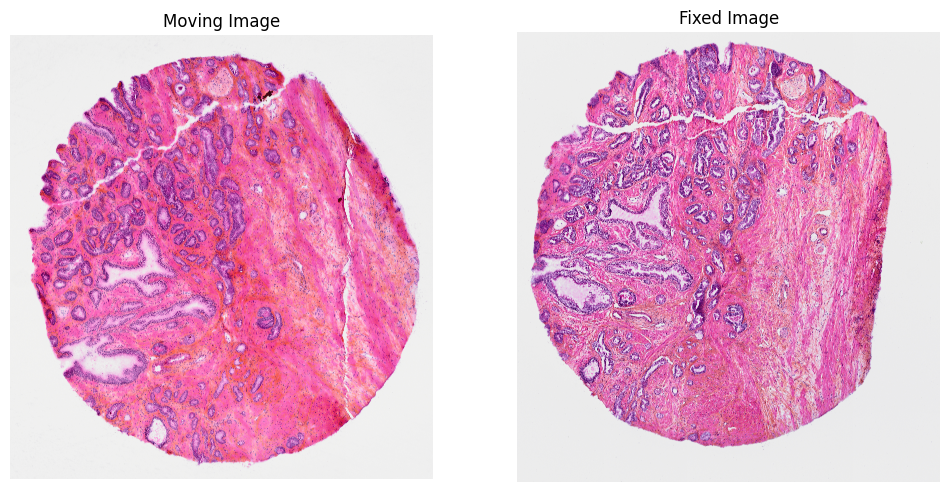

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')

### Step 2: Setting registration options and performing registration.

In [5]:
# Set this option only to True, if greedy is used as an external docker image.
# If MIIT, GreedyFHist and Greedy are used from with the same docker container or if
# from no docker container at all, set this to False.

# Normally, this option can stay as False.
use_greedyfhist_from_external_docker_container = False

if use_greedyfhist_from_external_docker_container:
    path_to_greedy = 'mwess89/greedy:1.3.0-alpha'
    use_docker_container = True
else:
    path_to_greedy = 'greedy'
    use_docker_container = False
    

registerer = GreedyFHist(path_to_greedy=path_to_greedy, use_docker_container=use_docker_container)

In [7]:
# Default options do not need to be parsed
options = RegistrationOptions()
options.affine_registration_options.n_threads = 8
options.nonrigid_registration_options.n_threads = 8
# For large images we recommend to use downscaling.
# options.pre_sampling_factor = 0.25

registration_result = registerer.register(moving_img=moving_image.data,
                                          fixed_img=fixed_image.data,
                                          options=options
                                          )

A registration result consists of 2 transformations: A forward transformation from moving to fixed image space and a backward transformation from fixed to moving image space. Internally transformations are executed using SimpleITK. Forward transformations are used to transform image data, backward transformations are used for pointset valued data.

In [8]:
warped_moving_image = registerer.transform_image(moving_image.data, registration_result.registration.forward_transform)

Text(0.5, 1.0, 'Transformed Image')

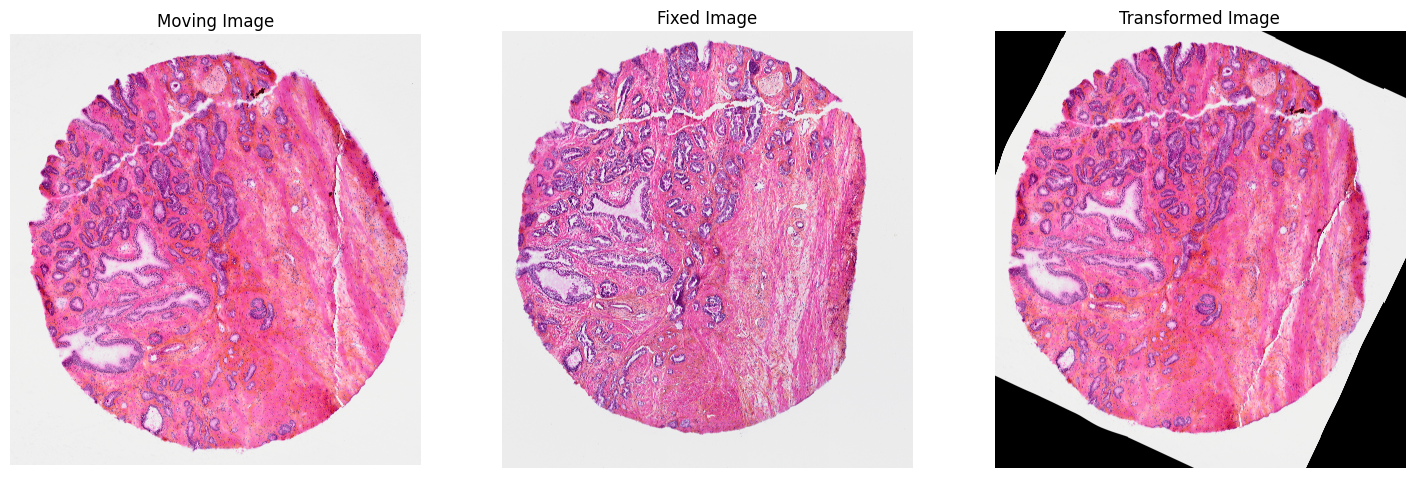

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')
axs[2].imshow(warped_moving_image)
axs[2].set_title('Transformed Image')

### Step 3: Saving and loading transformation data

Transformations can be stored and loaded at a later point.

In [10]:
registration_result.to_directory('saved_transform')
loaded_reg_result = RegistrationResult.load('saved_transform')

In [11]:
warped_image2 = registerer.transform_image(moving_image.data, loaded_reg_result.registration.forward_transform, 'LINEAR')

In [12]:
ps  = Pointset.load_from_path('../pairwise_examples/annotations/moving_pointset.csv')
warped_ps = registerer.transform_pointset(ps.to_numpy(), loaded_reg_result.registration.backward_transform)

Text(0.5, 1.0, 'Warped image from loaded registration.')

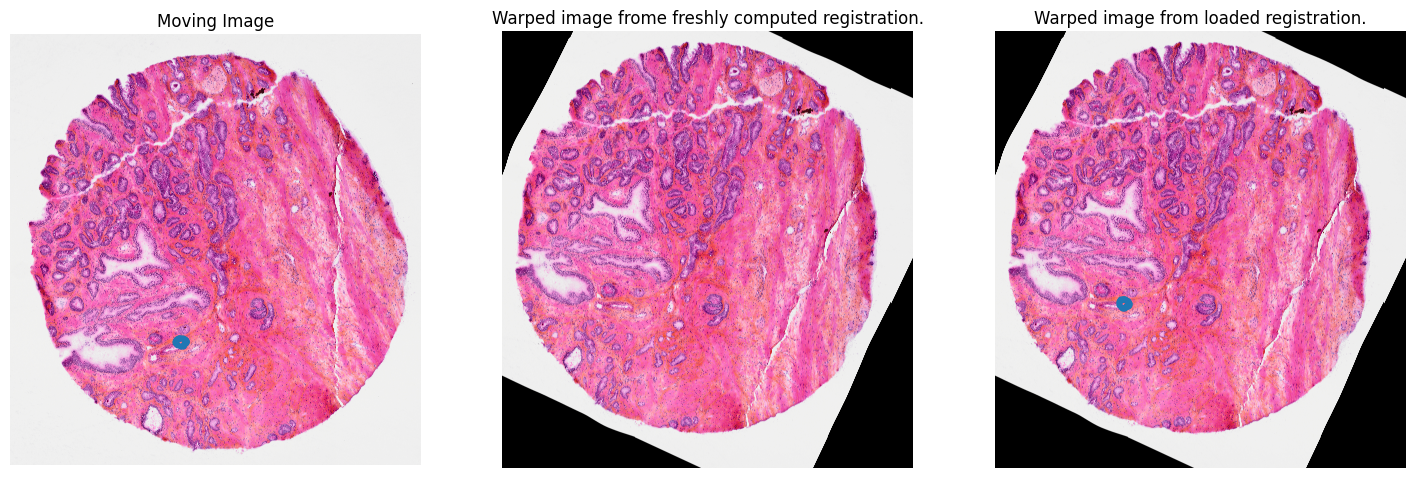

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18 ,6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
ps_np = ps.to_numpy()
axs[0].plot(ps_np[:, 0], ps_np[:, 1], '.')
axs[0].set_title('Moving Image')
axs[1].imshow(warped_moving_image)
axs[1].set_title('Warped image frome freshly computed registration.')
axs[2].imshow(warped_image2)
axs[2].plot(warped_ps[:, 0], warped_ps[:, 1], '.')
axs[2].set_title('Warped image from loaded registration.')